# Tables demo/ workbook 



In [1]:
# INITIALIZATION BOILERPLATE

# The Jupyter kernel for this notebook usually starts up inside the notebooks
# directory, but the text_extensions_for_pandas package code is in the parent
# directory. Add that parent directory to the front of the Python include path.
import sys
if (sys.path[0] != ".."):
    sys.path[0] = ".."

import json
import os
from ibm_watson import CompareComplyV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from ibm_watson import ApiException

import pandas as pd 
import regex
import text_extensions_for_pandas as tp
from IPython.core.display import HTML



In [2]:
def init_watson_table_api():
    # Retrieve the APIKEY for authentication
    apikey = os.environ.get("IBM_API_KEY_TABLES")
    if apikey is None:
        raise ValueError("Expected apikey in the environment variable 'IBM_API_KEY'")

    # Get the service URL for your IBM Cloud instance
    ibm_cloud_service_url = os.environ.get("IBM_SERVICE_URL_TABLES")
    if ibm_cloud_service_url is None:
        raise ValueError("Expected IBM cloud service URL in the environment variable 'IBM_SERVICE_URL'")

        #initialize the authenticator
    authenticator = IAMAuthenticator(apikey)
    compare_comply = CompareComplyV1(
        version = '2020-1-1',
        authenticator=authenticator
    )

    compare_comply.set_service_url(ibm_cloud_service_url)
    return compare_comply

In [3]:
base_example_path = "../resources/tables/"
file_names = [ "who_covid_report_table", "20-populous-countries", "cali-temp-chart", "california-population-chart", "double_header_table"]

archive_name = "archive"
#set to true to query watson
re_query_watson = False



In [4]:
#responses_dict = {}
if re_query_watson:
    print("This shouldn't happen")
    compare_comply = init_watson_table_api()
    for file_n in file_names:
        with open(f"{base_example_path}{file_n}.pdf", 'rb') as base_file:
            try:
                result = compare_comply.extract_tables(base_file).get_result()
                responses_dict[file_n] = result
            except ApiException as ex:
                print ("Method failed with status code " + str(ex.code) + ": " + ex.message)
     #archive file
    with open(f"{base_example_path}{archive_name}.json", 'w') as archive_file:
        json.dump(responses_dict, archive_file)
else:
    with open(f"{base_example_path}{archive_name}.json", 'r') as archive_file:
        responses_dict = json.load(archive_file)

In [5]:
#select a response and process it, printing the outputs
response = responses_dict["double_header_table"]
response

{'document': {'title': 'Document1',
  'html': '<?xml version=\'1.0\' encoding=\'UTF-8\' standalone=\'yes\'?><html>\n<head>\n    <meta content="text/html; charset=UTF-8" http-equiv="Content-Type"/><meta content="Zachary Eichenberger" name="author"/><meta content="2020-07-23" name="publicationdate"/><meta content="1" name="numPages"/><title>Document1</title><style>/**/\n .Calibri_Black_12_0{font-size: 12.0pt; font-family: Calibri; color: Black; }\n/**/</style></head>\n<body><table border="1" data-max-height="115.12005615234375" data-max-width="522.1603393554688" data-max-x="22.501543045043945" data-max-y="67.73318481445312" data-min-height="115.12005615234375" data-min-width="522.1603393554688" data-min-x="22.501543045043945" data-min-y="67.73318481445312" data-page="1"><tbody><tr><td colspan="1" colstart="1" rowspan="1" rowstart="1">\xa0</td><td colspan="2" colstart="2" rowspan="1" rowstart="1"><p indentation="1"><span class="Calibri_Black_12_0"><bbox height="7.584000587463379" page="1"

In [6]:
#most basic work flow for processing tables
dfs_dict = tp.watson_tables_parse_response(response)
table = tp.make_table(dfs_dict)
table

Three months ended September 30        \
                                                2005  2004   
Statatory tax rate                              35.0  36.0   
IRS audit settlement                            97.0  35.5   
Dividends received                              13.2   3.3   
Total tax rate                                  76.1   4.3   

                     Nine months ended September 30        
                                               2005  2004  
Statatory tax rate                             37.0  35.0  
IRS audit settlement                           58.0  15.2  
Dividends received                             15.4   4.7  
Total tax rate                                 38.8  15.1

# Break down process of reconstructing table: 

The raw JSON output is omitted for brevity

The first stage we see is the pandas-ified deconstructed table. This gives a good idea of the schema of data we are dealing with. It can be reached by running the ``` tp.watson_tables_parse_response(...)``` command. 
It contains information about the row headers, column headers and body cells and their contents


Next we have the value-attribute correlated table. This phase correlates each value wits respective row and header cells using information about cell ID' row and column numbers and other information from the original table. 

In [7]:
#select a response and process it, printing the outputs
response = responses_dict["double_header_table"]

dfs_dict = tp.watson_tables_parse_response(response)

print("displaying row headers:")
display(dfs_dict['row_headers'])
print("displaying column headers:")
display(dfs_dict['col_headers'])
print("displaying objects:")
display(dfs_dict['body_cells'].head(30))

displaying row headers:


,text,column_index_begin,column_index_end,row_index_begin,row_index_end,cell_id,text_normalized
0,Statatory tax rate,0,0,2,2,rowHeader-2810-2829,Statatory tax rate
1,IRS audit settlement,0,0,3,3,rowHeader-4068-4089,IRS audit settlement
2,Dividends received,0,0,4,4,rowHeader-5329-5348,Dividends received
3,Total tax rate,0,0,5,5,rowHeader-6586-6601,Total tax rate


displaying column headers:


,text,column_index_begin,column_index_end,row_index_begin,row_index_end,cell_id,text_normalized
0,,0,0,0,0,colHeader-786-787,
1,Three months ended September 30,1,2,0,0,colHeader-1012-1206,Three months ended September 30
2,Nine months ended September 30,3,4,0,0,colHeader-1444-1514,Nine months ended September 30
3,,0,0,1,1,colHeader-1586-1587,
4,2005,1,1,1,1,colHeader-1813-1818,2005
5,2004,2,2,1,1,colHeader-2061-2066,2004
6,2005,3,3,1,1,colHeader-2305-2310,2005
7,2004,4,4,1,1,colHeader-2553-2558,2004


displaying objects:


,text,column_index_begin,column_index_end,row_index_begin,row_index_end,cell_id,column_header_ids,column_header_texts,row_header_ids,row_header_texts,attributes.text,attributes.type
0,35%,1,1,2,2,bodyCell-3073-3077,"[colHeader-1012-1206, colHeader-1813-1818]","[Three months ended September 30, 2005]",[rowHeader-2810-2829],[Statatory tax rate],[35%],[Percentage]
1,36%,2,2,2,2,bodyCell-3320-3324,"[colHeader-1012-1206, colHeader-2061-2066]","[Three months ended September 30, 2004]",[rowHeader-2810-2829],[Statatory tax rate],[36%],[Percentage]
2,37%,3,3,2,2,bodyCell-3564-3568,"[colHeader-1444-1514, colHeader-2305-2310]","[Nine months ended September 30, 2005]",[rowHeader-2810-2829],[Statatory tax rate],[37%],[Percentage]
3,35%,4,4,2,2,bodyCell-3811-3815,"[colHeader-1444-1514, colHeader-2553-2558]","[Nine months ended September 30, 2004]",[rowHeader-2810-2829],[Statatory tax rate],[38%],[Percentage]
4,97%,1,1,3,3,bodyCell-4333-4337,"[colHeader-1012-1206, colHeader-1813-1818]","[Three months ended September 30, 2005]",[rowHeader-4068-4089],[IRS audit settlement],[97%],[Percentage]
5,35.5%,2,2,3,3,bodyCell-4579-4585,"[colHeader-1012-1206, colHeader-2061-2066]","[Three months ended September 30, 2004]",[rowHeader-4068-4089],[IRS audit settlement],[35.5%],[Percentage]
6,58%,3,3,3,3,bodyCell-4825-4829,"[colHeader-1444-1514, colHeader-2305-2310]","[Nine months ended September 30, 2005]",[rowHeader-4068-4089],[IRS audit settlement],[58%],[Percentage]
7,15.2%,4,4,3,3,bodyCell-5071-5077,"[colHeader-1444-1514, colHeader-2553-2558]","[Nine months ended September 30, 2004]",[rowHeader-4068-4089],[IRS audit settlement],[15.2%],[Percentage]
8,13.2%,1,1,4,4,bodyCell-5591-5597,"[colHeader-1012-1206, colHeader-1813-1818]","[Three months ended September 30, 2005]",[rowHeader-5329-5348],[Dividends received],[13.2%],[Percentage]
9,3.3%,2,2,4,4,bodyCell-5838-5843,"[colHeader-1012-1206, colHeader-2061-2066]","[Three months ended September 30, 2004]",[rowHeader-5329-5348],[Dividends received],[3.3%],[Percentage]


In [8]:
table_exploded, row_headers, col_headers = tp.make_exploded_df(dfs_dict)
display(table_exploded)

,text,row_header_texts_0,column_header_texts_0,column_header_texts_1,attributes.type
0,35%,Statatory tax rate,Three months ended September 30,2005,[Percentage]
1,36%,Statatory tax rate,Three months ended September 30,2004,[Percentage]
2,37%,Statatory tax rate,Nine months ended September 30,2005,[Percentage]
3,35%,Statatory tax rate,Nine months ended September 30,2004,[Percentage]
4,97%,IRS audit settlement,Three months ended September 30,2005,[Percentage]
5,35.5%,IRS audit settlement,Three months ended September 30,2004,[Percentage]
6,58%,IRS audit settlement,Nine months ended September 30,2005,[Percentage]
7,15.2%,IRS audit settlement,Nine months ended September 30,2004,[Percentage]
8,13.2%,Dividends received,Three months ended September 30,2005,[Percentage]
9,3.3%,Dividends received,Three months ended September 30,2004,[Percentage]


## Compare the reconstructed table with the extracted html from table understanding output

We run the final step of table reconstruction: `tp.make_table`. 
Note we could have run `make_table_from_exploded_dfs` here instead with the output of the last step. 

Additionally we render the html that is produced in an intermediate step by the table extraction api to give a comparison of the original vs reconstructed table

In [9]:
dfs_dict = tp.watson_tables_parse_response(response)
table = tp.make_table(dfs_dict)
display(table)
display(HTML(response["document"]["html"]))

Three months ended September 30        \
                                                2005  2004   
Statatory tax rate                              35.0  36.0   
IRS audit settlement                            97.0  35.5   
Dividends received                              13.2   3.3   
Total tax rate                                  76.1   4.3   

                     Nine months ended September 30        
                                               2005  2004  
Statatory tax rate                             37.0  35.0  
IRS audit settlement                           58.0  15.2  
Dividends received                             15.4   4.7  
Total tax rate                                 38.8  15.1

### Data manipulation while in pandas dataframe: 

Once the table is processed through into a pandas dataframe, it can be easily manipulated like any other pandas dataframe. 

Here, we show selecting rows, columns, specific heading combinations, and even specific items. Each of these is an easy to use one-liner

In [10]:
#change names of heading feilds
table= table.rename_axis(columns=["period","year"])
#display whole table
display(table)

period               Three months ended September 30        \
year                                            2005  2004   
Statatory tax rate                              35.0  36.0   
IRS audit settlement                            97.0  35.5   
Dividends received                              13.2   3.3   
Total tax rate                                  76.1   4.3   

period               Nine months ended September 30        
year                                           2005  2004  
Statatory tax rate                             37.0  35.0  
IRS audit settlement                           58.0  15.2  
Dividends received                             15.4   4.7  
Total tax rate                                 38.8  15.1

In [11]:
#select just one set duration
display(table.loc[:,"Nine months ended September 30"])

year,2005,2004
Statatory tax rate,37.0,35.0
IRS audit settlement,58.0,15.2
Dividends received,15.4,4.7
Total tax rate,38.8,15.1


In [12]:
# One specific time period 
display(table[("Nine months ended September 30","2005")].to_frame())

,Nine months ended September 30
,2005
Statatory tax rate,37.0
IRS audit settlement,58.0
Dividends received,15.4
Total tax rate,38.8


In [13]:
# Display data from just one year
display(table.swaplevel(axis=1)["2004"])

period,Three months ended September 30,Nine months ended September 30
Statatory tax rate,36.0,35.0
IRS audit settlement,35.5,15.2
Dividends received,3.3,4.7
Total tax rate,4.3,15.1


In [14]:
#select one specific field
display(table.loc["Dividends received",:].to_frame())

Dividends received
period                          year                    
Three months ended September 30 2005                13.2
                                2004                 3.3
Nine months ended September 30  2005                15.4
                                2004                 4.7

## Performing numeric analysis on table

Doing this, however enables rich analysis of the data provided, by leveraging the powerful data analytics side of pandas.
Here we show taking generating general descriptive statistics for the set; using `DataFrame.mean()`, `DataFrame.std()` and `DataFrame.describe()` however more in depth analytics are possible

In [15]:
temp = table.copy()
#now other analyses are possible
print("\nShow means by year")
display(temp.mean(axis=0).to_frame())


Show means by year


0
period                          year        
Three months ended September 30 2005  55.325
                                2004  19.775
Nine months ended September 30  2005  37.300
                                2004  17.500



Show means by subtype


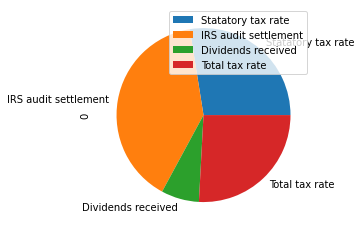

In [16]:
print("\n\nShow means by subtype")
display(temp.mean(axis=1).to_frame().plot(y=0,kind='pie'))

In [17]:
print("\n\nShow the deviation for each category")
display(temp.std(axis=1).to_frame())



Show the deviation for each category


,0
Statatory tax rate,0.957427
IRS audit settlement,35.053138
Dividends received,6.041247
Total tax rate,31.801612


In [18]:
print("\n\nGenerate general descriptive statistics for the whole dataFrame")
print("By time period:")
display(temp.describe(percentiles =[]))
print("By category:")
temp.transpose().describe(percentiles=[])



Generate general descriptive statistics for the whole dataFrame
By time period:


period Three months ended September 30             \
year                              2005       2004   
count                         4.000000   4.000000   
mean                         55.325000  19.775000   
std                          38.105238  18.451987   
min                          13.200000   3.300000   
50%                          55.550000  19.900000   
max                          97.000000  36.000000   

period Nine months ended September 30             
year                             2005       2004  
count                        4.000000   4.000000  
mean                        37.300000  17.500000  
std                         17.420677  12.664123  
min                         15.400000   4.700000  
50%                         37.900000  15.150000  
max                         58.000000  35.000000

By category:


,Statatory tax rate,IRS audit settlement,Dividends received,Total tax rate
count,4.000000,4.000000,4.000000,4.000000
mean,35.750000,51.425000,9.150000,33.575000
std,0.957427,35.053138,6.041247,31.801612
min,35.000000,15.200000,3.300000,4.300000
50%,35.500000,46.750000,8.950000,26.950000
max,37.000000,97.000000,15.400000,76.100000


## Application example: extracting data from WHO Covid report

This is an example of how you can use the the package in an end to end use to rapidly charactarize a set of data from pdf format

In [19]:
response_covid = responses_dict["who_covid_report_table"]
num_tabs = len(response_covid.get("tables", []))

df = pd.DataFrame()

for i in range (num_tabs):
    dfs_dict = tp.watson_tables_parse_response(response_covid, select_table=i)
    next_table = tp.make_table(dfs_dict,concat_with='', col_explode_by = "concat", convert_numeric_items=False,sort_headers=False)
    display(next_table)
    display(HTML(tp.get_raw_html(response_covid,dfs_dict)))
    df = df.append(next_table, ignore_index = True)

,Days since last reported case,Reporting Country/ Territory/Area,Total confirmed cases,Total confirmed new cases,Total deaths,Total new deaths,Transmission classification i
2,,Africa,,,,,
3,0,South Africa,287 796,11 554,4 172,93,Community transmission
4,0,Nigeria,33153,595,744,4,Community transmission
5,0,Ghana,24988,470,139,0,Community transmission
6,0,Algeria,19689,494,1 018,7,Community transmission
7,1,Cameroon,15173,0,359,0,Community transmission
8,0,Côƚe d͛Iǀoiƌe,12872,106,84,0,Community transmission
9,0,Kenya,10294,189,197,12,Community transmission
10,0,Senegal,8198,63,150,2,Community transmission
11,0,Democratic Republic of the Congo,8074,42,189,1,Community transmission


,Days since last reported case,Reporting Country/ Territory/Area,Total confirmed cases,Total confirmed new cases,Total deaths,Total new deaths,Transmission classification i
2,0,Cabo Verde,1722,24,19,0,Clusters of cases
3,0,Sierra Leone,1642,7,63,0,Community transmission
4,0,Eswatini,1389,38,20,0,Clusters of cases
5,2,Benin,1378,0,26,0,Community transmission
6,0,Rwanda,1378,41,4,0,Sporadic cases
7,0,Mozambique,1219,62,9,0,Clusters of cases
8,3,Niger,1099,0,68,0,Community transmission
9,51,Equatorial Guinea,1043,0,12,0,Community transmission
10,0,Burkina Faso,1036,3,53,0,Community transmission
11,0,Zimbabwe,1034,49,19,1,Sporadic cases


,Days since last reported case,Reporting Country/ Territory/Area,Total confirmed cases,Total confirmed new cases,Total deaths,Total new deaths,Transmission classification i
2,4,Eritrea,232,0,0,0,Sporadic cases
3,4,Seychelles,100,0,0,0,Clusters of cases
4,4,Gambia,64,0,3,0,Sporadic cases
5,,Territories ii,,,,,
6,0,Mayotte,2 724,13,40,0,Clusters of cases
7,0,Réunion,596,3,3,0,Clusters of cases
8,,Americas,,,,,
9,0,United States of America,3 286 063,60 113,134 704,312,Community transmission
10,0,Brazil,1 864 681,24 831,72 100,631,Community transmission
11,0,Peru,326326,3 616,11 870,188,Community transmission


Reporting Country/ Territory/Area,Total confirmed,Total confirmed,Total deaths,Total new deaths,Transmission,Days since last
,cases,new cases,,,classificationi,reported case
Eritrea,232,0,0,0,Sporadic cases,4
Seychelles,100,0,0,0,Clusters of cases,4
Gambia,64,0,3,0,Sporadic cases,4
Territoriesii,,,,,,
Mayotte,2 724,13,40,0,Clusters of cases,0
Réunion,596,3,3,0,Clusters of cases,0
Americas,,,,,,
United States of America,3 286 063,60 113,134 704,312,Community transmission,0
Brazil,1 864 681,24 831,72 100,631,Community transmission,0


,Days since last reported case,Reporting Country/ Territory/Area,Total confirmed cases,Total confirmed new cases,Total deaths,Total new deaths,Transmission classification i
2,0,Haiti,6 727,37,139,0,Community transmission
3,0,Paraguay,2 980,160,25,4,Community transmission
4,0,Cuba,2 428,2,87,0,Clusters of cases
5,5,Nicaragua,2 411,0,91,0,Community transmission
6,0,Uruguay,987,1,31,1,Clusters of cases
7,0,Suriname,762,21,18,0,Clusters of cases
8,1,Jamaica,758,0,10,0,Clusters of cases
9,0,Guyana,297,6,17,0,Clusters of cases
10,7,Trinidad and Tobago,133,0,8,0,Sporadic cases
11,1,Bahamas,111,0,11,0,Clusters of cases


Reporting Country/ Territory/Area,Total confirmed,Total confirmed,Total deaths,Total new deaths,Transmission,Days since last
,cases,new cases,,,classificationi,reported case
Haiti,6 727,37,139,0,Community transmission,0
Paraguay,2 980,160,25,4,Community transmission,0
Cuba,2 428,2,87,0,Clusters of cases,0
Nicaragua,2 411,0,91,0,Community transmission,5
Uruguay,987,1,31,1,Clusters of cases,0
Suriname,762,21,18,0,Clusters of cases,0
Jamaica,758,0,10,0,Clusters of cases,1
Guyana,297,6,17,0,Clusters of cases,0
Trinidad and Tobago,133,0,8,0,Sporadic cases,7


,Days since last reported case,Reporting Country/ Territory/Area,Total confirmed cases,Total confirmed new cases,Total deaths,Total new deaths,Transmission classification i
2,3,Guadeloupe,190,0,14,0,Clusters of cases
3,2,Bermuda,150,0,9,0,Sporadic cases
4,7,Aruba,105,0,3,0,Sporadic cases
5,10,Sint Maarten,78,0,15,0,No cases
6,0,Turks and Caicos Islands,72,1,2,0,Clusters of cases
7,9,Saint Martin,44,0,3,0,Sporadic cases
8,0,Curaçao,26,1,1,0,Sporadic cases
9,79,Falkland Islands (Malvinas),13,0,0,0,No cases
10,3,Montserrat,12,0,1,0,No cases
11,59,British Virgin Islands,8,0,1,0,No cases


,Days since last reported case,Reporting Country/ Territory/Area,Total confirmed cases,Total confirmed new cases,Total deaths,Total new deaths,Transmission classification i
2,0,Afghanistan,34 740,289,1 045,35,Clusters of cases
3,0,Bahrain,33 476,535,109,1,Clusters of cases
4,0,Morocco,15 936,191,255,5,Clusters of cases
5,0,Sudan,10 316,66,657,7,Community transmission
6,0,Djibouti,4977,5,56,0,Clusters of cases
7,0,Somalia,3072,13,93,0,Sporadic cases
8,0,Lebanon,2419,85,36,0,Clusters of cases
9,0,Libya,1512,79,40,1,Clusters of cases
10,0,Yemen,1502,33,425,7,Community transmission
11,0,Tunisia,1302,39,50,0,Sporadic cases


,Days since last reported case,Reporting Country/ Territory/Area,Total confirmed cases,Total confirmed new cases,Total deaths,Total new deaths,Transmission classification i
2,0,Belgium,62781,74,9 787,5,Community transmission
3,0,Kazakhstan,61755,1 856,375,0,Clusters of cases
4,0,Ukraine,54771,638,1 412,14,Community transmission
5,0,Netherlands,51038,71,6 128,0,Community transmission
6,0,Portugal,46818,306,1 662,2,Community transmission
7,0,Israel,39294,1 279,364,7,Pending
8,0,Poland,38190,299,1 576,5,Community transmission
9,0,Romania,32948,413,1 901,17,Community transmission
10,0,Switzerland,32861,148,1 685,0,Community transmission
11,0,Armenia,32490,339,581,8,Community transmission


,Days since last reported case,Reporting Country/ Territory/Area,Total confirmed cases,Total confirmed new cases,Total deaths,Total new deaths,Transmission classification i
2,0,Tajikistan,6 595,44,55,0,Pending
3,0,Luxembourg,4956,31,111,0,Community transmission
4,0,Hungary,4247,13,595,0,Community transmission
5,0,Greece,3826,23,193,0,Clusters of cases
6,0,Croatia,3775,53,119,0,Clusters of cases
7,0,Albania,3667,96,97,2,Clusters of cases
8,2,Estonia,2014,0,69,0,Clusters of cases
9,0,Slovakia,1902,1,28,0,Clusters of cases
10,0,Iceland,1900,4,10,0,Community transmission
11,0,Lithuania,1874,5,79,0,Community transmission


,Days since last reported case,Reporting Country/ Territory/Area,Total confirmed cases,Total confirmed new cases,Total deaths,Total new deaths,Transmission classification i
2,53,Isle of Man,336,0,24,0,No cases
3,0,Jersey,329,4,31,0,Community transmission
4,72,Guernsey,252,0,13,0,Community transmission
5,6,Faroe Islands,188,0,0,0,Pending
6,3,Gibraltar,180,0,0,0,Clusters of cases
7,46,Greenland,13,0,0,0,No cases
8,,South-East Asia,,,,,
9,0,India,906 752,28 498,23 727,553,Clusters of cases
10,0,Bangladesh,186 894,3 099,2 391,39,Community transmission
11,0,Indonesia,76 981,1 282,3 656,50,Community transmission


Reporting Country/ Territory/Area,Total confirmed,Total confirmed,Total deaths,Total new deaths,Transmission,Days since last
,cases,new cases,,,classificationi,reported case
Isle of Man,336,0,24,0,No cases,53
Jersey,329,4,31,0,Community transmission,0
Guernsey,252,0,13,0,Community transmission,72
Faroe Islands,188,0,0,0,Pending,6
Gibraltar,180,0,0,0,Clusters of cases,3
Greenland,13,0,0,0,No cases,46
South-East Asia,,,,,,
India,906 752,28 498,23 727,553,Clusters of cases,0
Bangladesh,186 894,3 099,2 391,39,Community transmission,0


,Days since last reported case,Reporting Country/ Territory/Area,Total confirmed cases,Total confirmed new cases,Total deaths,Total new deaths,Transmission classification i
2,0,Australia,9 980,183,108,0,Clusters of cases
3,0,Malaysia,8 725,7,122,0,Clusters of cases
4,0,New Zealand,1 195,1,22,0,Clusters of cases
5,1,Viet Nam,372,0,0,0,Clusters of cases
6,1,Mongolia,230,0,0,0,Sporadic cases
7,0,Cambodia,165,9,0,0,Sporadic cases
8,67,Brunei Darussalam,141,0,3,0,No cases
9,2,Fiji,26,0,0,0,Sporadic cases
10,92,Lao People's Democratic Republic,19,0,0,0,Sporadic cases
11,18,Papua New Guinea,11,0,0,0,Sporadic cases


Reporting Country/ Territory/Area,Total confirmed,Total confirmed,Total deaths,Total new deaths,Transmission,Days since last
,cases,new cases,,,classificationi,reported case
Australia,9 980,183,108,0,Clusters of cases,0
Malaysia,8 725,7,122,0,Clusters of cases,0
New Zealand,1 195,1,22,0,Clusters of cases,0
Viet Nam,372,0,0,0,Clusters of cases,1
Mongolia,230,0,0,0,Sporadic cases,1
Cambodia,165,9,0,0,Sporadic cases,0
Brunei Darussalam,141,0,3,0,No cases,67
Fiji,26,0,0,0,Sporadic cases,2
Lao People's Democratic Republic,19,0,0,0,Sporadic cases,92


In [20]:
#use pandas functionality to remove bad data (~5 rows that were misinterpereted by table extraction as data when they were sub-headers)
rows_to_keep = [r.to_list().count('') == 0 for _,r in df.iterrows()] 
#df = df[rows_to_keep]
df

,Days since last reported case,Reporting Country/ Territory/Area,Total confirmed cases,Total confirmed new cases,Total deaths,Total new deaths,Transmission classification i
0,,Africa,,,,,
1,0,South Africa,287 796,11 554,4 172,93,Community transmission
2,0,Nigeria,33153,595,744,4,Community transmission
3,0,Ghana,24988,470,139,0,Community transmission
4,0,Algeria,19689,494,1 018,7,Community transmission
...,...,...,...,...,...,...,...
225,2,(Commonwealth of the),33,0,2,0,Pending
226,34,New Caledonia,21,0,0,0,Sporadic cases
227,,Subtotal for all regions,12 964 068,196 775,570 275,3 634,
228,-,Other*,741,0,13,0,Not applicable


In [21]:
num_cols = ['Days since last reported case', 'Total confirmed cases', 'Total confirmed new cases', 'Total deaths','Total new deaths']
df_converted = tp.convert_cols_to_numeric(df, columns=num_cols, cast_type= float)


ERROR READING VALUE:""	 Filling with <NA>
ERROR READING VALUE:""	 Filling with <NA>
ERROR READING VALUE:""	 Filling with <NA>
ERROR READING VALUE:""	 Filling with <NA>
ERROR READING VALUE:""	 Filling with <NA>
ERROR READING VALUE:""	 Filling with <NA>
ERROR READING VALUE:""	 Filling with <NA>
ERROR READING VALUE:""	 Filling with <NA>
ERROR READING VALUE:""	 Filling with <NA>
ERROR READING VALUE:""	 Filling with <NA>
ERROR READING VALUE:""	 Filling with <NA>
ERROR READING VALUE:""	 Filling with <NA>
ERROR READING VALUE:""	 Filling with <NA>
ERROR READING VALUE:"-"	 Filling with <NA>
ERROR READING VALUE:""	 Filling with <NA>
ERROR READING VALUE:""	 Filling with <NA>
ERROR READING VALUE:""	 Filling with <NA>
ERROR READING VALUE:""	 Filling with <NA>
ERROR READING VALUE:""	 Filling with <NA>
ERROR READING VALUE:""	 Filling with <NA>
ERROR READING VALUE:""	 Filling with <NA>
ERROR READING VALUE:""	 Filling with <NA>
ERROR READING VALUE:""	 Filling with <NA>
ERROR READING VALUE:""	 Filling w

In [28]:
df_converted.head(30)

,Days since last reported case,Reporting Country/ Territory/Area,Total confirmed cases,Total confirmed new cases,Total deaths,Total new deaths,Transmission classification i
0,<NA>,Africa,<NA>,<NA>,<NA>,<NA>,
1,0,South Africa,287796,11554,4172,93,Community transmission
2,0,Nigeria,33153,595,744,4,Community transmission
3,0,Ghana,24988,470,139,0,Community transmission
4,0,Algeria,19689,494,1018,7,Community transmission
5,1,Cameroon,15173,0,359,0,Community transmission
6,0,Côƚe d͛Iǀoiƌe,12872,106,84,0,Community transmission
7,0,Kenya,10294,189,197,12,Community transmission
8,0,Senegal,8198,63,150,2,Community transmission
9,0,Democratic Republic of the Congo,8074,42,189,1,Community transmission


In [23]:
df_converted.describe()

,Days since last reported case,Reporting Country/ Territory/Area,Total confirmed cases,Total confirmed new cases,Total deaths,Total new deaths,Transmission classification i
count,215.0,230,218.0,218.0,218.0,218.0,230
unique,30.0,226,211.0,123.0,145.0,40.0,7
top,0.0,Territories ii,12.0,0.0,0.0,0.0,Community transmission
freq,152.0,5,2.0,64.0,27.0,130.0,87


In [24]:
table

period               Three months ended September 30        \
year                                            2005  2004   
Statatory tax rate                              35.0  36.0   
IRS audit settlement                            97.0  35.5   
Dividends received                              13.2   3.3   
Total tax rate                                  76.1   4.3   

period               Nine months ended September 30        
year                                           2005  2004  
Statatory tax rate                             37.0  35.0  
IRS audit settlement                           58.0  15.2  
Dividends received                             15.4   4.7  
Total tax rate                                 38.8  15.1

In [25]:
#select a response and process it, printing the outputs
response = responses_dict["double_header_table"]

dfs_dict = tp.watson_tables_parse_response(response)

table_exploded, row_headers, col_headers = tp.make_exploded_df(dfs_dict)

tp.make_table_from_exploded_df(table_exploded, row_headers, col_headers, dfs_dict=dfs_dict)

Three months ended September 30         \
                                                2005   2004   
Statatory tax rate                               35%    36%   
IRS audit settlement                             97%  35.5%   
Dividends received                             13.2%   3.3%   
Total tax rate                                 76.1%   4.3%   

                     Nine months ended September 30         
                                               2005   2004  
Statatory tax rate                              37%    35%  
IRS audit settlement                            58%  15.2%  
Dividends received                            15.4%   4.7%  
Total tax rate                                38.8%  15.1%

In [26]:
def make_table_from_exploded_df(exploded_df: pd.DataFrame, row_heading_cols, column_heading_cols, dfs_dict=None,
                                value_col: str = "text", concat_with: str = " | ",
                                convert_numeric_items=False) -> pd.DataFrame:

    table = exploded_df.pivot_table(index=row_heading_cols, columns=column_heading_cols, values=value_col,
                                    aggfunc=(lambda a: concat_with.join(a)))
    row_nones = [None for _ in range(len(row_heading_cols))]
    col_nones = [None for _ in range(len(column_heading_cols))]


        
    row_headings = table.index.to_list()
    rows = dfs_dict["row_headers"][dfs_dict["row_headers"]["text"].isin(row_headings)]
    rows = rows.sort_values("row_index_begin")
    row_headings_sorted = rows["text"].to_list()
    table = table.reindex(row_headings_sorted)
    
    headers = table.columns.to_frame()
    sorted_headers_arr = _order_index(headers, column_heading_cols, 0, dfs_dict["col_headers"])
    sorted_headers = [tuple(header) for header in sorted_headers_arr]
    table = table[sorted_headers]
    
    if convert_numeric_items:
        num_rows, num_cols = _infer_numeric_rows_cols(exploded_df, row_heading_cols, column_heading_cols)
        table = _convert_cols_to_numeric(table, num_cols, num_rows)
        
    return table.rename_axis(index=row_nones, columns=col_nones)


def _order_index(headers, exploded_col, spot, header_df):
    col = exploded_col[spot]
    uniques = headers[col].unique()
    uniques_sorted = header_df[header_df["text"].isin(uniques)].sort_values("column_index_begin")["text"].drop_duplicates().to_list()
    ans = []
    for unique in uniques_sorted: 
        if spot < (len(exploded_col)-1): 
            arr = _order_index(headers.loc[unique],exploded_col, spot+1, header_df)
            for ar in arr: 
                ar.insert(0,unique)
                ans.append(ar)
        else: 
            ans.append([unique])
    return ans
        
    

make_table_from_exploded_df(table_exploded, row_headers, col_headers, dfs_dict=dfs_dict)

Three months ended September 30         \
                                                2005   2004   
Statatory tax rate                               35%    36%   
IRS audit settlement                             97%  35.5%   
Dividends received                             13.2%   3.3%   
Total tax rate                                 76.1%   4.3%   

                     Nine months ended September 30         
                                               2005   2004  
Statatory tax rate                              37%    35%  
IRS audit settlement                            58%  15.2%  
Dividends received                            15.4%   4.7%  
Total tax rate                                38.8%  15.1%

In [27]:
def _horiz_explode(df_in, column, drop_original=True):

    # expands list of columns
    df = df_in.copy()
    # expand df.tags into its own dataframe
    tags = df[column].apply(pd.Series)
    tags = tags.rename(columns=lambda x: column + '_' + str(x))
    df = pd.concat([df[:], tags[:]], axis=1)

    if drop_original:
        df.drop(columns=column, inplace=True)
    return df, tags.columns.to_list()

rows = dfs_dict["row_headers"]
cols = dfs_dict["col_headers"]
dict(zip([1,3,4,5],["one", "three","four","five"]))
row_dict = rows.set_index("cell_id")["text"].to_dict()
col_dict = cols.set_index("cell_id")["text"].to_dict()

exploded_id,row_header_cols = _horiz_explode(dfs_dict["body_cells"],"row_header_ids")
exploded_id, col_header_cols = _horiz_explode(exploded_id,"column_header_ids")
tab = tp.make_table_from_exploded_df(exploded_id, row_header_cols, col_header_cols)
tab.rename(index = row_dict,columns=col_dict)

Three months ended September 30         \
                                                2005   2004   
Statatory tax rate                               35%    36%   
IRS audit settlement                             97%  35.5%   
Dividends received                             13.2%   3.3%   
Total tax rate                                 76.1%   4.3%   

                     Nine months ended September 30         
                                               2005   2004  
Statatory tax rate                              37%    35%  
IRS audit settlement                            58%  15.2%  
Dividends received                            15.4%   4.7%  
Total tax rate                                38.8%  15.1%